#Project preparations, data exploration

## Set up

### Libraries

In [1]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 38.2MB 72kB/s 
     |████████████████████████████████| 952kB 20.0MB/s 
albumentations==0.5.2 is successfully installed


In [2]:
import sys
import os
import glob
import random
import time
import pickle

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
from sklearn.model_selection import train_test_split

# Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use("dark_background")

## Data

### Fetching Data

In [3]:
def fetch_data(kaggle_config_dir):
    os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir
    # changing the working directory
    %cd $kaggle_config_dir
    !kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
    #unzipping the zip files and deleting the zip files
    !unzip \*.zip  && rm *.zip

In [4]:
#Run at first
#fetch_data('/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project')

In [5]:
%cd '/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project'
!ls

/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project
 BestModels
 Data
'Dataset Visualization'
 kaggle.json
 predictions_of_unet_with_resnext50_backbone0.png
 predictions_of_unet_with_resnext50_backbone1.png
 predictions_of_unet_with_resnext50_backbone2.png
 predictions_of_unet_with_resnext50_backbone3.png
 predictions_of_unet_with_resnext50_backbone4.png
 predictions_of_unet_with_resnext50_backbone5.png
 predictions_of_unet_with_resnext50_backbone6.png
 save.pkl
 TOAI_DL.ipynb


In [6]:
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/data.csv')
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


LGG Segmentation Dataset
This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks. The images were obtained from The Cancer Imaging Archive (TCIA). They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available. Tumor genomic clusters and patient data is provided in data.csv file.

All images are provided in .tif format with 3 channels per image. For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels). For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing. Missing sequences are replaced with FLAIR sequence to make all images 3-channel. Masks are binary, 1-channel images. They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).

The dataset is organized into 110 folders named after case ID that contains information about source institution. Each folder contains MR images with the following naming convention:

`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`

Corresponding masks have a _mask suffix.

### Data Preprocessing

In [7]:
print(len('/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_'))
print(len('.tif'))
print(len('_mask.tif'))

103
4
9


In [8]:
DATA_PATH = '/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data'

# File path line length images for later sorting
BASE_LEN = 103 # len('/content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_')
END_IMG_LEN = 4 # len('.tif')
END_MASK_LEN = 9 # len('_mask.tif')

# img size
IMG_SIZE = 512

In [9]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"/*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
#dirname every 
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()# Raw data

This is not a dir: /content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/README.md
This is not a dir: /content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/data.csv


,dirname,path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...


### Mapping patient images and masks by path

In [10]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [11]:
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_24.tif 
Path to the Mask: /content/drive/MyDrive/ColabNotebooks/TOAI_DL_Project/Data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_24_mask.tif


In [12]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})

df

,patient,image_path,mask_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
...,...,...,...
3924,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
3925,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
3926,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...
3927,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...


In [13]:
"""
TESTING
for i, mask in enumerate(df.mask_path):
    val = np.max(cv2.imread(mask))
    if val > 1:
        print(i)
tumor = cv2.imread(df.iloc[758].mask_path)
tumor.shape
for v in np.nditer(tumor):
    if v > 0:
        print(v)
df.iloc[758].mask_path
"""

'\nTESTING\nfor i, mask in enumerate(df.mask_path):\n    val = np.max(cv2.imread(mask))\n    if val > 1:\n        print(i)\ntumor = cv2.imread(df.iloc[758].mask_path)\ntumor.shape\nfor v in np.nditer(tumor):\n    if v > 0:\n        print(v)\ndf.iloc[758].mask_path\n'

### Adding Diagnosis

In [14]:
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

#df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
#df

In [15]:
#pickle.dump(df, open("save.pkl", "wb"))
df = pickle.load(open("save.pkl", "rb"))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
3925,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
3926,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0
3927,TCGA_HT_A61B_19991127,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,/content/drive/MyDrive/ColabNotebooks/TOAI_DL_...,0


## EDA

### Quantitative plots

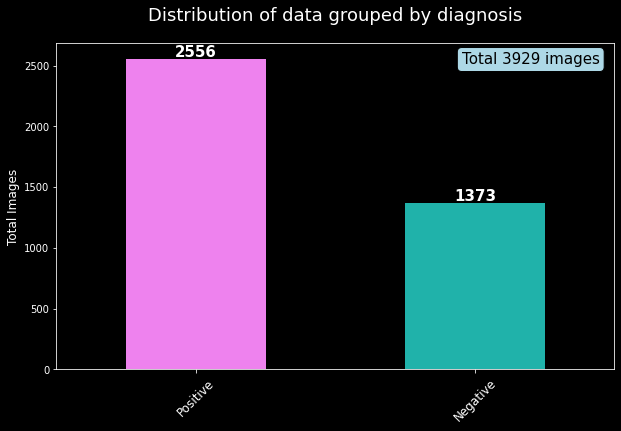

In [ ]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-10), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );
plt.show()

In [ ]:
df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)

diagnosis,0,1
patient,,
TCGA_CS_4941_19960909,23.0,0.0
TCGA_CS_4942_19970222,20.0,0.0
TCGA_CS_4943_20000902,20.0,0.0
TCGA_CS_4944_20010208,20.0,0.0
TCGA_CS_5393_19990606,20.0,0.0
...,...,...
TCGA_HT_8563_19981209,14.0,9.0
TCGA_HT_A5RC_19990831,25.0,7.0
TCGA_HT_A616_19991226,23.0,5.0


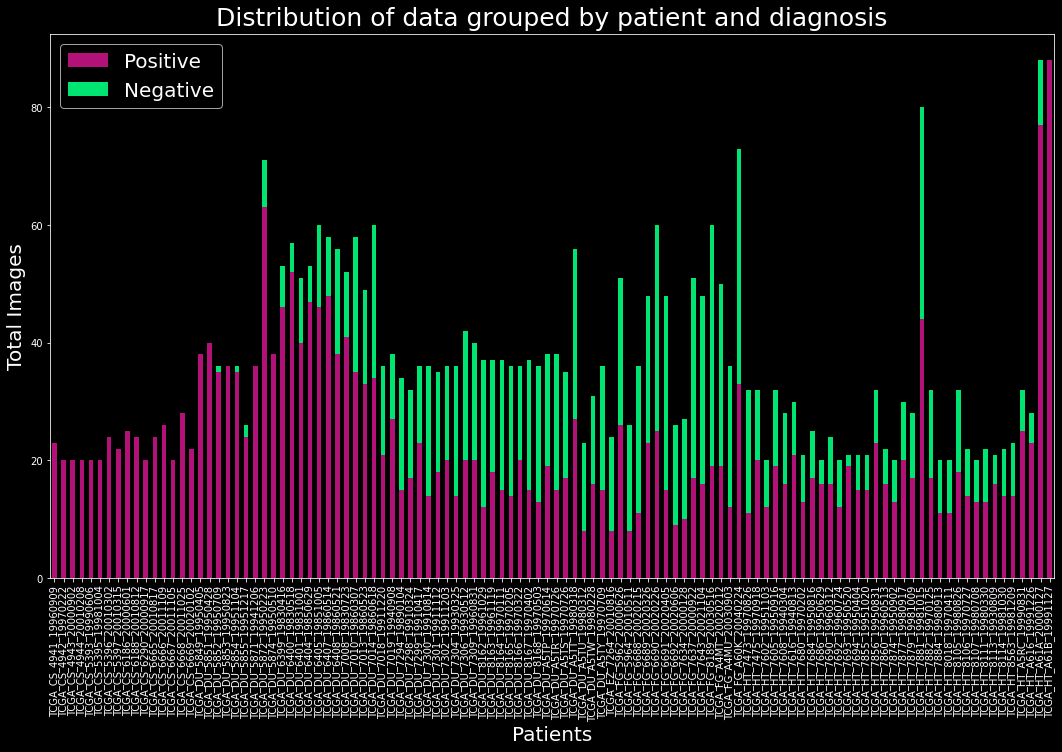

In [ ]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)
plt.show()

In [ ]:
sample_positive_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_negative_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_negative_df, sample_negative_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])

sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

### Image, Mask Plots

In [ ]:
# Data
sample_positive_df = df[df["diagnosis"] == 1].sample(4).image_path.values
sample_negative_df = df[df["diagnosis"] == 0].sample(4).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_positive_df, sample_negative_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
#Testing
from google.colab.patches import cv2_imshow
sample_df = df[df["diagnosis"] == 1]
sample_df.iloc[444]
img = cv2.imread(sample_df.iloc[444][1])
mask = cv2.imread(sample_df.iloc[444][2])
print( img.shape )
cv2_imshow(img)
print( mask.shape )
cv2_imshow(mask)
"""

'\n#Testing\nfrom google.colab.patches import cv2_imshow\nsample_df = df[df["diagnosis"] == 1]\nsample_df.iloc[444]\nimg = cv2.imread(sample_df.iloc[444][1])\nmask = cv2.imread(sample_df.iloc[444][2])\nprint( img.shape )\ncv2_imshow(img)\nprint( mask.shape )\ncv2_imshow(mask)\n'

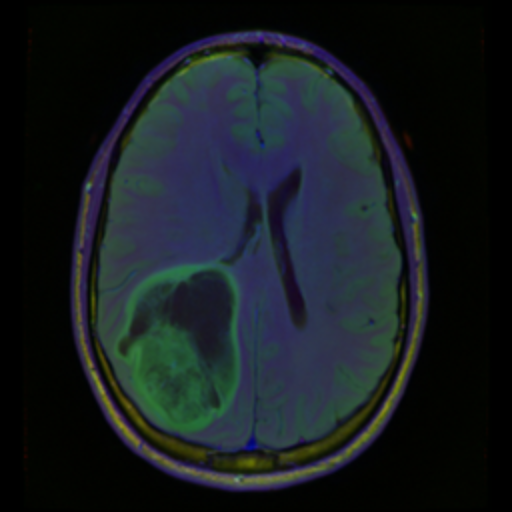

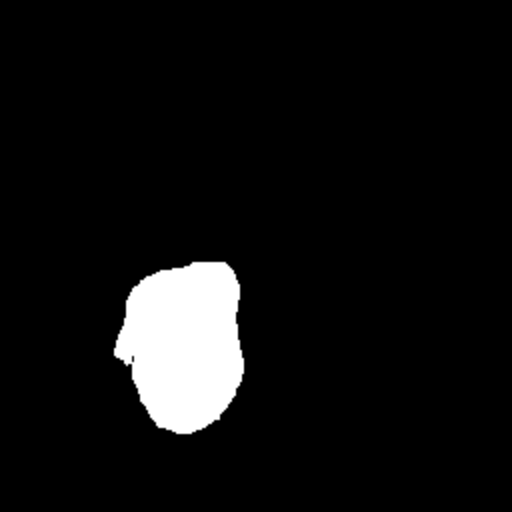

In [ ]:
"""
#Testing
from google.colab.patches import cv2_imshow
sample_df = df[df["diagnosis"] == 1]
sample_df.iloc[444]
img = cv2.resize(cv2.imread(sample_df.iloc[444][1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(sample_df.iloc[444][2]), (IMG_SIZE, IMG_SIZE))
cv2_imshow(img)
cv2_imshow(mask)
"""

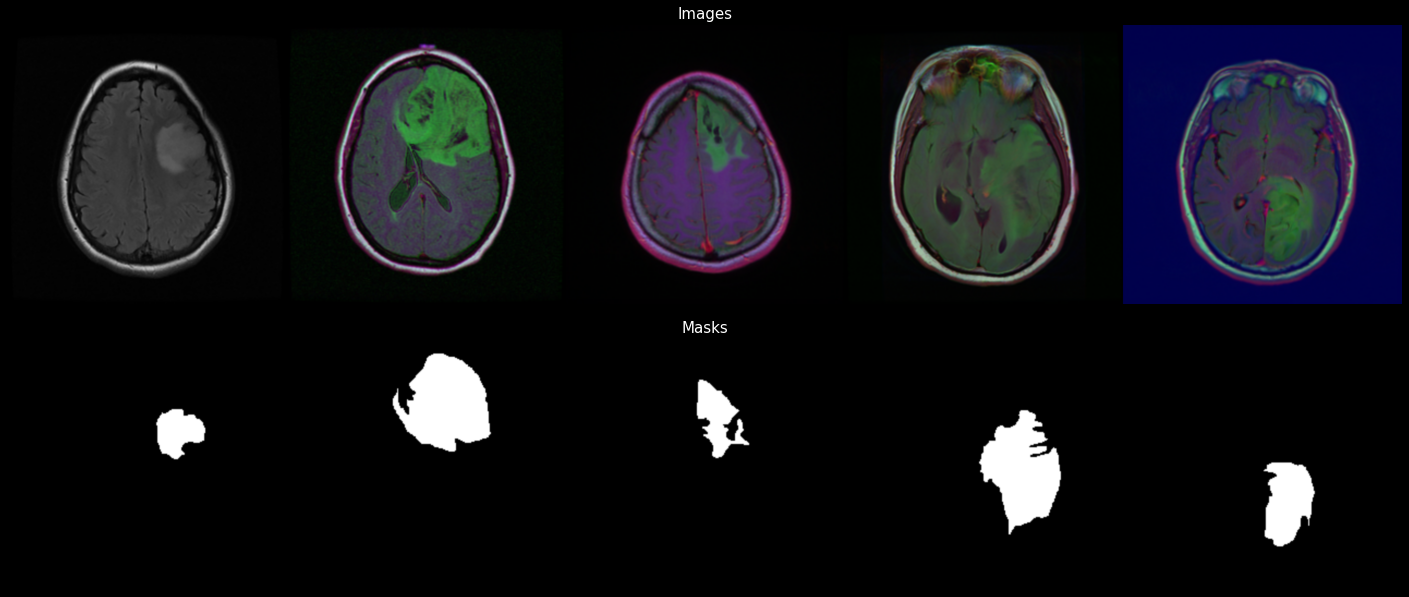

In [ ]:
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x1 (row x column) grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.savefig("datasetmasks.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

## Data Loader

### Dataset




*   cv2.IMREAD_COLOR: It specifies to load a color image. Any transparency of image will be neglected. It is the default flag. Alternatively, we can pass integer value 1 for this flag.
*   cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.



In [ ]:
??cv2.imread

In [ ]:
??A.Normalize

### Transforms(data augmentation)

In [16]:
RESIZE_SIZE = 128

transforms = A.Compose([
    A.Resize(width = RESIZE_SIZE, height = RESIZE_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    #ToTensor(),
    ToTensorV2(),
])

In [17]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormalize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)  

In [ ]:
??ToTensor

In [ ]:
??ToTensorV2

### Train-val-test

In [18]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [19]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=24, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=24, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=24, num_workers=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Augmentation Visualization

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


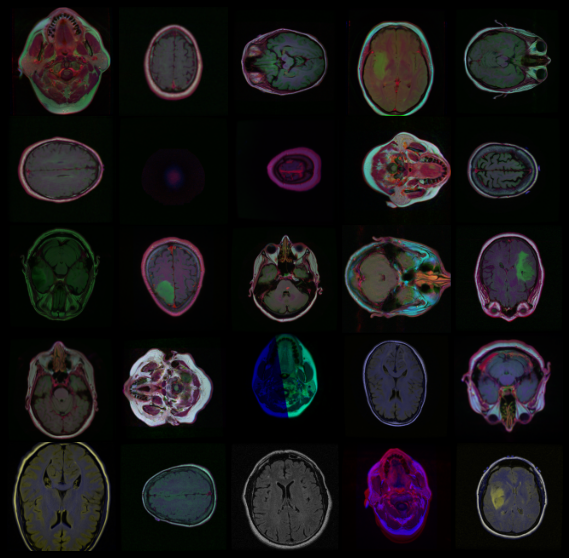

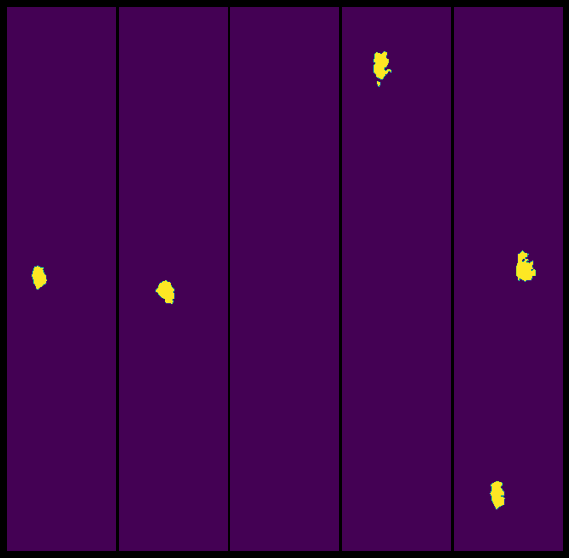

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = abs((img*std+mean)).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.min(), img.max())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
    if image is True:
        plt.savefig("img_aug.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
    else:
        plt.savefig("mask_aug.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# Models

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
!nvidia-smi

Wed May 19 15:57:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## UNet

In [22]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [23]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [24]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


## Unet with ResNeXt50 backbone

In [25]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        #// Floor Division
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [26]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [27]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



torch.Size([1, 1, 256, 256])


# Training

## Metrics

In [28]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [29]:
# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

In [30]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [31]:
# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [32]:
def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

## Training loop

In [33]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch %d" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

## Optimizers, callbacks

In [34]:
# Optimizers
unet_optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
%%time
# Train UNet
unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, True, 20) 

Vanila_UNet


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0
Mean loss on train: 0.9265424604045933 
Mean DICE on train: 0.2224026231437415 
Mean DICE on validation: 0.4505100270240232
Epoch 1
Mean loss on train: 0.6045980229973793 
Mean DICE on train: 0.47640764206531283 
Mean DICE on validation: 0.6828051611747173
Epoch 2
Mean loss on train: 0.59009792835548 
Mean DICE on train: 0.4854832929848916 
Mean DICE on validation: 0.6045457941834046
Epoch 3
Mean loss on train: 0.5635077806896177 
Mean DICE on train: 0.5076809801493526 
Mean DICE on validation: 0.563979976840216
Epoch 4
Mean loss on train: 0.5528891898434738 
Mean DICE on train: 0.5141218891575217 
Mean DICE on validation: 0.6188501189385797
Epoch 5
Mean loss on train: 0.535578548651317 
Mean DICE on train: 0.5349426436929225 
Mean DICE on validation: 0.6026542923814603
Epoch 6
Mean loss on train: 0.527011559055797 
Mean DICE on train: 0.5366969937508494 
Mean DICE on validation: 0.6669023868220684
Epoch 7
Mean loss on train: 0.4875444159682455 
Mean DICE on train: 0.5709863487

In [35]:
unet_model = UNet(n_classes=1).to(device)

In [36]:
unet_model.load_state_dict(torch.load('./BestModels/Vanila_UNet_17_epoch.pt'))

<All keys matched successfully>

### Baseline model Vanila UNet performance
Best model at:

Epoch 17

Mean loss on train: 0.344 

Mean DICE on train: 0.698

Mean DICE on validation: 0.79

In [ ]:
%%time
num_ep = 15 
# Train ResNeXt50
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, True, num_ep)

ResNeXt50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0
Mean loss on train: 0.9121726436604713 
Mean DICE on train: 0.22492250504193104 
Mean DICE on validation: 0.8060214078549139
Epoch 1
Mean loss on train: 0.27549668915312864 
Mean DICE on train: 0.7711885003498592 
Mean DICE on validation: 0.8030856487633836
Epoch 2
Mean loss on train: 0.2714135441286811 
Mean DICE on train: 0.7772512534523528 
Mean DICE on validation: 0.800004838081533
Epoch 3
Mean loss on train: 0.22230023582433833 
Mean DICE on train: 0.8074384756852676 
Mean DICE on validation: 0.8411456959543339
Epoch 4
Mean loss on train: 0.1975742144959754 
Mean DICE on train: 0.8297547360001507 
Mean DICE on validation: 0.86426318384526
Epoch 5
Mean loss on train: 0.20187871023241816 
Mean DICE on train: 0.821537786773568 
Mean DICE on validation: 0.9101939290982123
Epoch 6
Mean loss on train: 0.17768106262745528 
Mean DICE on train: 0.8454766095927349 
Mean DICE on validation: 0.8328233191775152
Epoch 7
Mean loss on train: 0.19451766756588015 
Mean DICE on train: 0.8313

### UNet with ResNeXt50 backbone
Best model fit at:

Epoch 13

Mean loss on train: ~0.137

Mean DICE on train: ~0.878

Mean DICE on validation: ~0.94

In [37]:
rx50_model = ResNeXtUNet(n_classes=1).to(device)
rx50_model.load_state_dict(torch.load('./BestModels/ResNeXt50_13_epoch.pt'))

<All keys matched successfully>

# Results

## Training visualization

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()

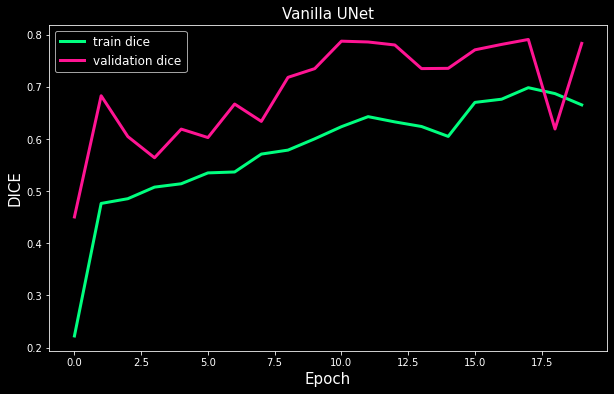

In [ ]:
plot_model_history("Vanilla UNet", unet_th, unet_vh, 20)

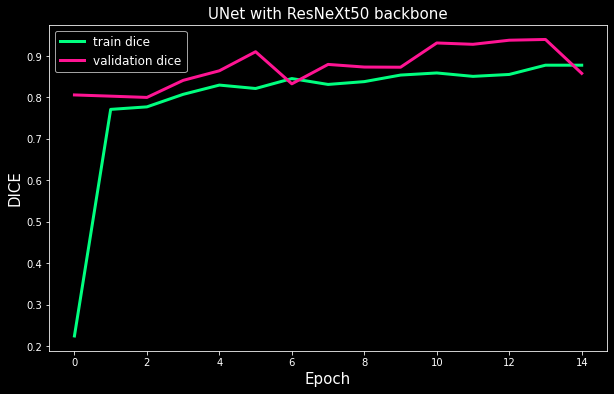

In [ ]:
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

## Test set segmentation visualization

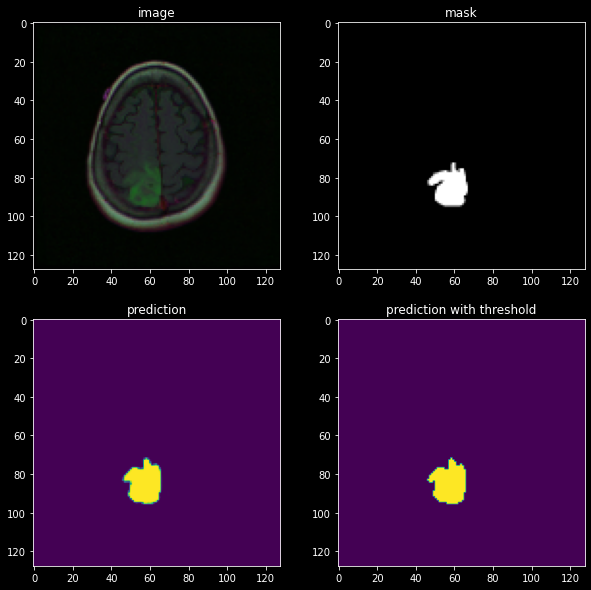

In [ ]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [38]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values

In [39]:
def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(rx50_model, test_samples)

In [41]:
# rx plates
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [46]:
# PLOT
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.show()

In [48]:
titlerx = "Predictions of UNet with ResNeXt50 backbone"
for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch, titlerx, num)

Output hidden; open in https://colab.research.google.com to view.

# Other stuff

### Code


In [50]:
while True:pass

KeyboardInterrupt: ignored

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in rx50.state_dict():
    print(param_tensor, "\t", rx50.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in rx50_optimizer.state_dict():
    print(var_name, "\t", rx50_optimizer.state_dict()[var_name])

In [ ]:
strong_transforms = A.Compose([
    A.RandomResizedCrop(width = RESIZE_SIZE, height = RESIZE_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensorV2(),
])

In [ ]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x



class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [ ]:
class FPN(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
         
        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.maxpool = nn.MaxPool2d(2)
        
        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        
        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        
        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4)) 
        
        # Top-down
        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) 
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)
        
        out = torch.sigmoid(out)
        return out

In [ ]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
fpn_optimizer = torch.optim.Adam(fpn.parameters(), lr=1e-3)
# Train FPN
#fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)#
#plot_model_history("FPN", fpn_th, fpn_vh, 20)
#prediction_overlap_f = batch_preds_overlap(fpn, test_samples)
#...

In [ ]:
prediction_overlap_u = batch_preds_overlap(unet_model, test_samples)
# unet plates
pred_overlap_5x1_u = []
pred_overlap_5x3_u = []
for i in range(5, 105+5, 5):
    pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))
for i in range(3, 21+3, 3):
    pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))
    prediction_overlap_u = batch_preds_overlap(unet_model, test_samples)

### Links

*   https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
*   https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
*   https://pytorch.org/docs/stable/notes/cuda.html
*   https://pytorch.org/hub/pytorch_vision_resnext/
*   https://github.com/MaciejMazurowski/brain-segmentation
*   https://albumentations.ai/docs/
*   https://albumentations.ai/docs/examples/pytorch_classification/
*   http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf
*   https://www.mslivingwell.org/learn-more-about-ms/understanding-your-mri/
*   https://pytorch.org/hub/pytorch_vision_resnext/
*   https://dzlab.github.io/dl/2019/03/16/pytorch-training-loop/
*   https://arxiv.org/pdf/2004.05645.pdf
*   https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9107080
*   https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

**...**

